In [1]:
import torch
from utils import load_ckpt, visualize_depth
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics
import numpy as np

from datasets import dataset_dict

torch.backends.cudnn.benchmark = True

In [4]:
# Change to your settings...
############################
N_vocab = 1500
encode_appearance = True
N_a = 48
encode_transient = True
N_tau = 16
beta_min = 0.03 # doesn't have effect in testing
session_name = '20220726T162250+0800_xvnxa_xvnxa001_gzns_2jmw2'
ckpt_path = 'ckpts/' + session_name + '/epoch=2.ckpt'

N_emb_xyz = 10
N_emb_dir = 4
N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32
#############################

embedding_xyz = PosEmbedding(N_emb_xyz-1, N_emb_xyz)
embedding_dir = PosEmbedding(N_emb_dir-1, N_emb_dir)
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}
if encode_appearance:
    embedding_a = torch.nn.Embedding(N_vocab, N_a).cuda()
    load_ckpt(embedding_a, ckpt_path, model_name='embedding_a')
    embeddings['a'] = embedding_a
if encode_transient:
    embedding_t = torch.nn.Embedding(N_vocab, N_tau).cuda()
    load_ckpt(embedding_t, ckpt_path, model_name='embedding_t')
    embeddings['t'] = embedding_t
    

nerf_coarse = NeRF('coarse',
                   in_channels_xyz=6*N_emb_xyz+3,
                   in_channels_dir=6*N_emb_dir+3).cuda()
nerf_fine = NeRF('fine',
                 in_channels_xyz=6*N_emb_xyz+3,
                 in_channels_dir=6*N_emb_dir+3,
                 encode_appearance=encode_appearance,
                 in_channels_a=N_a,
                 encode_transient=encode_transient,
                 in_channels_t=N_tau,
                 beta_min=beta_min).cuda()

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

models = {'coarse': nerf_coarse, 'fine': nerf_fine}

In [3]:
@torch.no_grad()
def f(rays, ts, **kwargs):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        kwargs_ = {}
        if 'a_embedded' in kwargs:
            kwargs_['a_embedded'] = kwargs['a_embedded'][i:i+chunk]
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        False,
                        test_time=True,
                        **kwargs_)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

# Test on the image of Fig 4 in the paper

In [6]:
dataset = dataset_dict['phototourism'] \
          ('data/' + session_name,
           split='test_train',
           img_downscale=8, use_cache=True)

In [7]:
sample = dataset[51]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


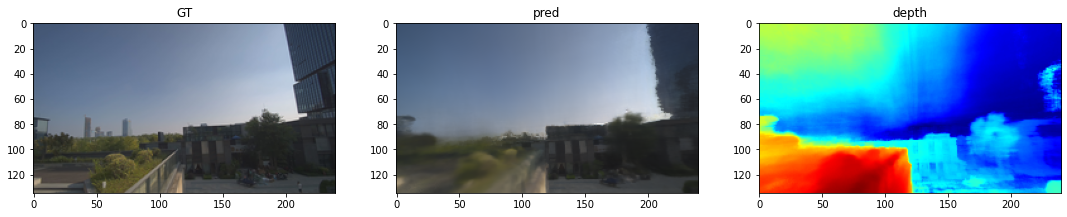

PSNR between GT and pred: 27.520767211914062 

Decomposition-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


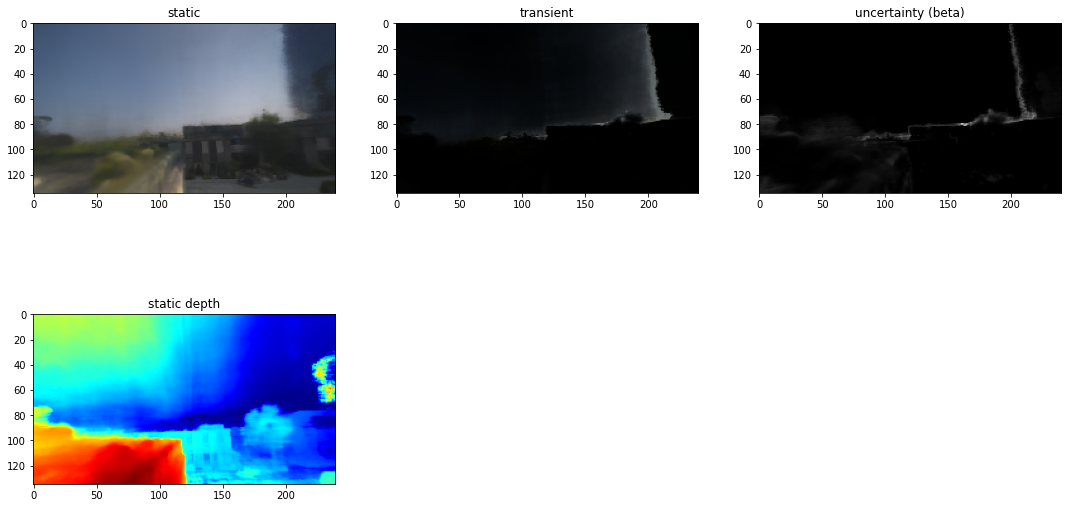

In [8]:
img_wh = tuple(sample['img_wh'].numpy())
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')


if encode_transient:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    beta = results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results['_rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(231)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(232)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(233)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray')
    plt.subplot(234)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.show()

## Make a small gif

In [5]:
from datasets.ray_utils import *

def get_test_rays(pose, K, img_h, img_w, t = 1, near = 0.1, far = 5):
    c2w = torch.FloatTensor(pose)
    directions = get_ray_directions(img_h, img_w, K)
    rays_o, rays_d = get_rays(directions, c2w)
    rays = torch.cat([rays_o, rays_d,
                      near * torch.ones_like(rays_o[:, :1]),
                      far * torch.ones_like(rays_o[:, :1])],
                      1) # (h*w, 8)
    ts = t * torch.ones(len(rays), dtype=torch.long)
    return rays, ts

def render_images(f, poses, K, img_h, img_w, t = 1, near = 0.1, far = 5):
    img_preds = []
    depth_preds = []
    for pose in poses:
        rays, ts = get_test_rays(pose, K, image_h, image_w)
        results = f(rays.cuda(), ts.cuda())
        img_pred = results['rgb_fine'].view(image_h, image_w, 3).cpu().numpy()
        depth_pred = results['depth_fine'].view(image_h, image_w)
        img_preds.append(img_pred)
        depth_preds.append(depth_pred)
    return img_preds, depth_preds

In [6]:
# make demo poses
resize_ratio = 2
image_w = 240 * resize_ratio
image_h = 135 * resize_ratio
focal = 110 * resize_ratio
K = np.array([
    [focal,0,image_w / 2],
    [0,focal,image_h / 2],
    [0,0,1],
], dtype=np.float32)

render_poses = []
for i in range(10):
    x = (i - 5) / 25 
    render_pose = np.array([
        [1,0,0,x],
        [0,-1,0,0],
        [0,0,-1,0],
    ], dtype=np.float32)
    render_poses.append(render_pose)

img_preds, depth_preds = render_images(f, render_poses, K, image_h, image_w)

In [13]:
from PIL import Image

frames = []
for i in range(len(img_preds)):
    image = 255 * img_preds[i]
    depth = 255 * visualize_depth(depth_preds[i]).permute(1,2,0)
    image_t = np.concatenate((image, depth), axis=1)
    frames.append(Image.fromarray(image_t.astype('uint8'), 'RGB'))

length = len(frames)
for i in np.arange(1, length - 1):
    id_t = length - 2 - i
    frames.append(frames[id_t])
    
    
frame_one = frames[0]
frame_one.save("data/" + session_name + "/demo.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)

![image](data/dm_jmw.gif)

## Get Mesh
### Query network on dense 3d grid of points

In [40]:
from tqdm import tqdm

N = 50
xmin, xmax = -2, 2
ymin, ymax = -2, 2
zmin, zmax = -2, 2
# assert xmax-xmin == ymax-ymin == zmax-zmin, 'the ranges must have the same length!'
x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)
z = np.linspace(zmin, zmax, N)

xyz_ = torch.FloatTensor(np.stack(np.meshgrid(x, y, z), -1).reshape(-1, 3)).cuda()
dir_ = torch.zeros_like(xyz_).cuda()
ts_ = torch.ones(len(xyz_), dtype=torch.long).cuda()

print('Predicting occupancy ...')

model = 'coarse'
with torch.no_grad():
    B = xyz_.shape[0]
    out_chunks = []
    for i in tqdm(range(0, B, chunk)):
        xyz_embedded = embeddings['xyz'](xyz_[i:i+chunk])
        if model == 'coarse':
            out_chunks += [nerf_coarse(xyz_embedded, sigma_only=True)]
        else:
            dir_embedded = embeddings['dir'](dir_[i:i+chunk])
            a_embedded = embeddings['a'](ts_[i:i+chunk])
            t_embedded = embeddings['t'](ts_[i:i+chunk])

            inputs = [xyz_embedded, dir_embedded, a_embedded, t_embedded]
            out_chunks += [nerf_fine(torch.cat(inputs, 1))]
        
    rgbsigma = torch.cat(out_chunks, 0)

if model == 'coarse':
    sigma_id = 0
else:
    sigma_id = 3
sigma = rgbsigma[:, sigma_id].cpu().numpy()
sigma = np.maximum(sigma, 0).reshape(N, N, N)

Predicting occupancy ...


100%|██████████| 4/4 [00:00<00:00, 675.76it/s]


In [45]:
import mcubes

sigma_threshold = 60.0
# perform marching cube algorithm to retrieve vertices and triangle mesh
print('Extracting mesh ...')
vertices, triangles = mcubes.marching_cubes(sigma, sigma_threshold)
print('done', vertices.shape, triangles.shape)

Extracting mesh ...
done (22914, 3) (43733, 3)


In [46]:
import trimesh

mesh = trimesh.Trimesh(vertices / N - .5, triangles)
mesh.show()